# Lecture 5 (partial) – Data 100, Fall 2023

**Mauna Loa EDA Demo (meant for lecture 5)**

Data 100, Fall 2023

This demo was meant for Lecture 5, we ran out of time in lecture.  This notebook only contains the Mauna Loa part of the full Lecture 5 EDA Notebook.

[Acknowledgments Page](https://ds100.org/fa23/acks/)

A demo of data cleaning and exploratory data analysis using the CDC Tuberculosis data and the Mauna Loa CO2 data.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

---
<br/><br/>

## Data Faithfulness: Mauna Loa CO2 data

CO2 concentrations have been monitored at Mauna Loa Observatory since 1958 ([website link](https://gml.noaa.gov/ccgg/trends/data.html)).




In [3]:
co2_file = "data/co2_mm_mlo.txt"

Let's do some **EDA**!!

### How do we read the file into Pandas?
Let's instead check out this file with JupyterLab.

* Note it's a `.txt` file.
* Do we trust this file extension?
* What structure is it?


---
<br/><br/><br/><br/><br/>

Looking at the first few lines of the data, we spot some relevant characteristics:

- The values are separated by white space, possibly tabs.
- The data line up down the rows. For example, the month appears in 7th to 8th position of each line.
- The 71st and 72nd lines in the file contain column headings split over two lines.

We can use `read_csv` to read the data into a Pandas data frame, and we provide several arguments to specify that the separators are white space, there is no header (**we will set our own column names**), and to skip the first 72 rows of the file.

In [4]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = r'\s+'       #delimiter for continuous whitespace (stay tuned for regex next lecture))
)
co2.head()

,0,1,2,3,4,5,6
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


Congratulations! You've wrangled the data!

<br/>

...But our columns aren't named.
**We need to do more EDA.**

### Exploring Variable Feature Types

The NOAA [webpage](https://gml.noaa.gov/ccgg/trends/) might have some useful tidbits (in this case it doesn't).
Let's go back to the raw data file to identify each feature.


We'll rerun `pd.read_csv`, but this time with some **custom column names.**

In [5]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = '\s+', #regex for continuous whitespace (next lecture)
    names = ['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'Days']
)
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


### Visualizing CO2 

Scientific studies tend to have very clean data, right...? Let's jump right in and make a time series plot of CO2 monthly averages.

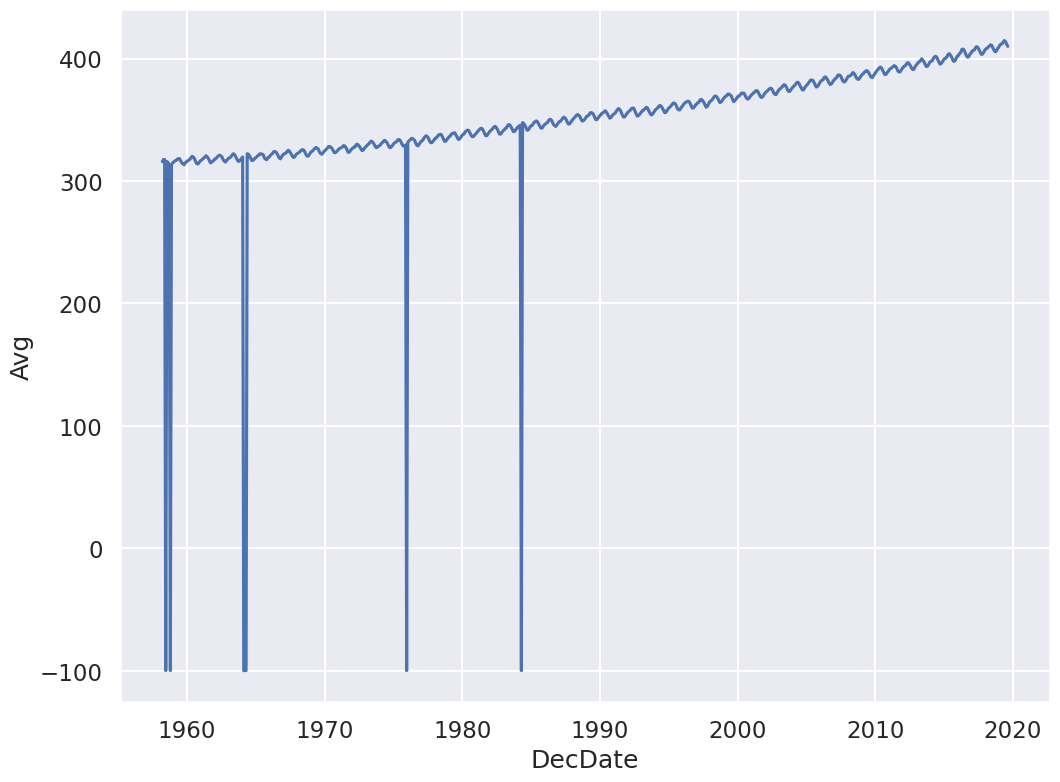

In [6]:
sns.lineplot(x='DecDate', y='Avg', data=co2);

The code above uses the `seaborn` plotting library (abbreviated `sns`). We will cover this on Thursday, but now you don't need to worry about how it works!


Yikes! Plotting the data uncovered a problem. It looks like we have some **missing values**. What happened here? 

In [7]:
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


In [8]:
co2.tail()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
733,2019,4,2019.29,413.32,413.32,410.49,26
734,2019,5,2019.38,414.66,414.66,411.20,28
735,2019,6,2019.46,413.92,413.92,411.58,27
736,2019,7,2019.54,411.77,411.77,411.43,23
737,2019,8,2019.62,409.95,409.95,411.84,29


Some data have unusual values like -1 and -99.99.

Let's check the description at the top of the file again.
1. -1 signifies a missing value for the number of days `Days` the equipment was in operation that month.
1. -99.99 denotes a missing monthly average `Avg`

How can we fix this? First, let's explore other aspects of our data. Understanding our data will help us decide what to do with the missing values.

<br/>


### Sanity Checks: Reasoning about the data
First, we consider the shape of the data. How many rows should we have?
* If chronological order, we should have one record per month.
* Data from March 1958 to August 2019.
* We should have $ 12 \times (2019-1957) - 2 - 4 = 738 $ records.

In [9]:
co2.shape

(738, 7)

Nice!! The number of rows (i.e. records) match our expectations.

<br/><br/>

---

Let's now check the quality of each feature.

### Understanding Missing Value 1: `Days`
`Days` is a time field, so let's analyze other time fields to see if there is an explanation for missing values of days of operation.

Let's start with **months** `Mo`.

Are we missing any records? The number of months should have 62 or 61 instances (March 1957-August 2019).

In [10]:
co2["Mo"].value_counts().sort_index()

Mo
1     61
2     61
3     62
4     62
5     62
6     62
7     62
8     62
9     61
10    61
11    61
12    61
Name: count, dtype: int64

As expected Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62.

<br/><br/>

Next let's explore **days** `Days` itself, which is the number of days that the measurement equipment worked.

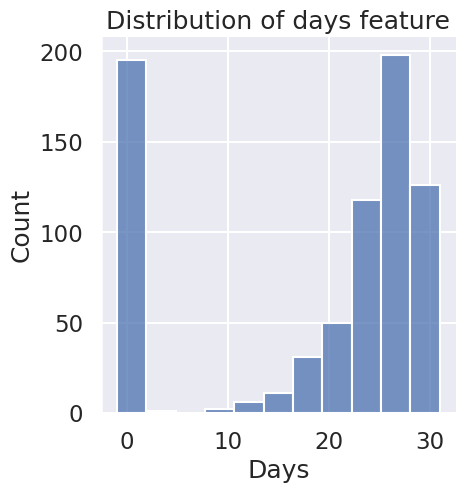

In [11]:
sns.displot(co2['Days']);
plt.title("Distribution of days feature"); # suppresses unneeded plotting output

In terms of data quality, a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values--**that's about 27% of the data**!

<br/><br/>

Finally, let's check the last time feature, **year** `Yr`.

Let's check to see if there is any connection between missingness and the year of the recording.

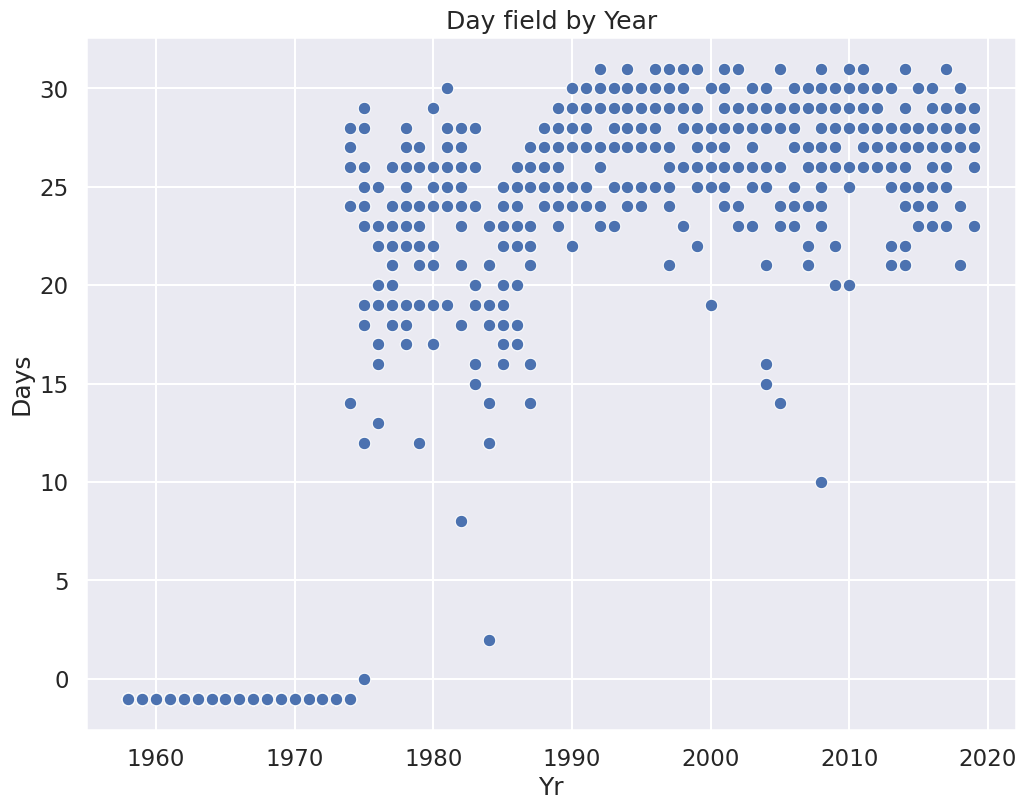

In [12]:
sns.scatterplot(x="Yr", y="Days", data=co2);
plt.title("Day field by Year"); # the ; suppresses output

**Observations**:

* All of the missing data are in the early years of operation.
* It appears there may have been problems with equipment in the mid to late 80s.

**Potential Next Steps**:
* Confirm these explanations through documentation about the historical readings.
* Maybe drop earliest recordings? However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems.

---
<br/><br/>

### Understanding Missing Value 2: `Avg`
Next, let's return to the -99.99 values in `Avg` to analyze the overall quality of the CO2 measurements.

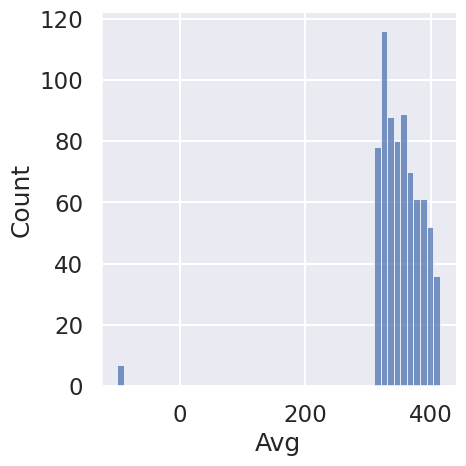

In [13]:
# Histograms of average CO2 measurements
sns.displot(co2['Avg']);

The non-missing values are in the 300-400 range (a regular range of CO2 levels).

We also see that there are only a few missing `Avg` values (**<1% of values**). Let's examine all of them:

In [14]:
co2[co2["Avg"] < 0]

,Yr,Mo,DecDate,Avg,Int,Trend,Days
3,1958,6,1958.46,-99.99,317.10,314.85,-1
7,1958,10,1958.79,-99.99,312.66,315.61,-1
71,1964,2,1964.12,-99.99,320.07,319.61,-1
72,1964,3,1964.21,-99.99,320.73,319.55,-1
73,1964,4,1964.29,-99.99,321.77,319.48,-1
213,1975,12,1975.96,-99.99,330.59,331.60,0
313,1984,4,1984.29,-99.99,346.84,344.27,2


There doesn't seem to be a pattern to these values, other than that most records also were missing `Days` data.

### Drop, `NaN`, or Impute Missing `Avg` Data?

How should we address the invalid `Avg` data?

A. Drop records

B. Set to NaN

C. Impute using some strategy

Remember we want to fix the following plot:

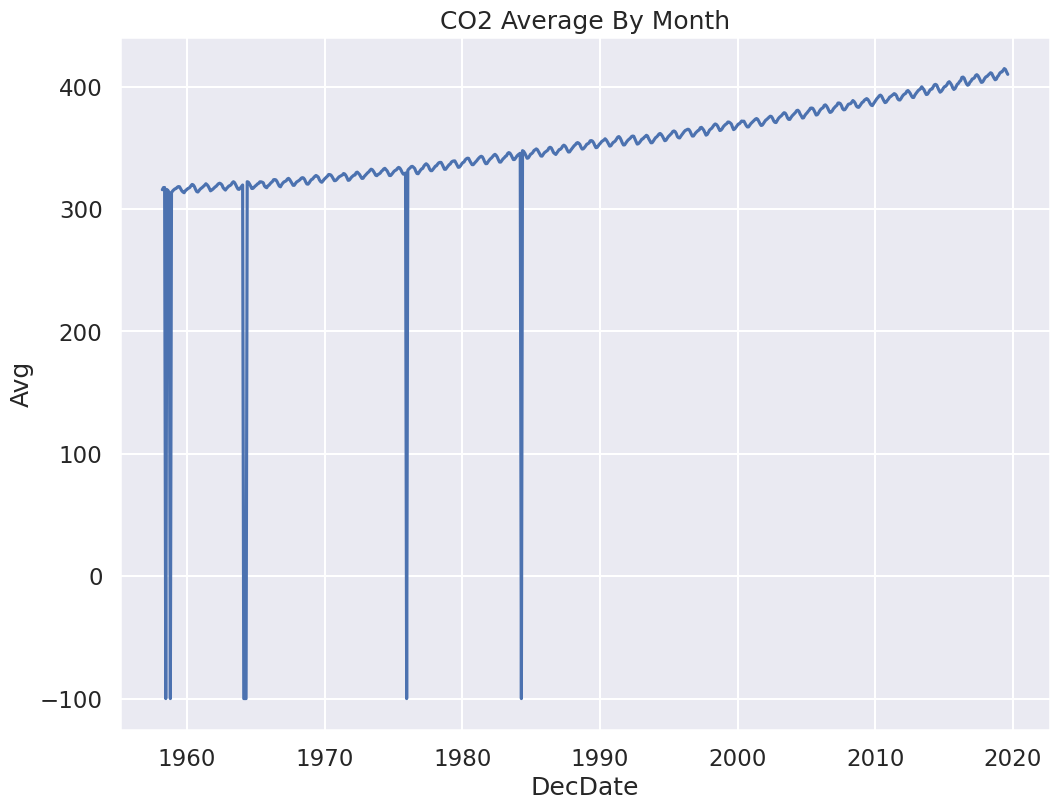

In [15]:
sns.lineplot(x='DecDate', y='Avg', data=co2)
plt.title("CO2 Average By Month");

Since we are plotting `Avg` vs `DecDate`, we should just focus on dealing with missing values for `Avg`.

Let's consider a few options:
1. Drop those records
1. Replace -99.99 with NaN
1. Substitute it with a likely value for the average CO2?

What do you think are the pros and cons of each possible action?

---
<br/><br/>
Let's examine each of these three options.

In [16]:
# 1. Drop missing values
co2_drop = co2[co2['Avg'] > 0]

# 2. Replace NaN with -99.99
co2_NA = co2.replace(-99.99, np.NaN)

We'll also use a third version of the data.
First, we note that the dataset already comes with a **substitute value** for the -99.99.

From the file description:

>  The `interpolated` column includes average values from the preceding column (`average`)
and **interpolated values** where data are missing.  Interpolated values are
computed in two steps...

The `Int` feature has values that exactly match those in `Avg`, except when `Avg` is -99.99, and then a **reasonable** estimate is used instead.
So, the third version of our data will use the `Int` feature instead of `Avg`.

In [17]:
# 3. Use interpolated column which estimates missing Avg values
co2_impute = co2.copy()
co2_impute['Avg'] = co2['Int']

<br/>

---

What's a **reasonable** estimate?

To answer this question, let's zoom in on a short time period, say the measurements in 1958 (where we know we have two missing values).


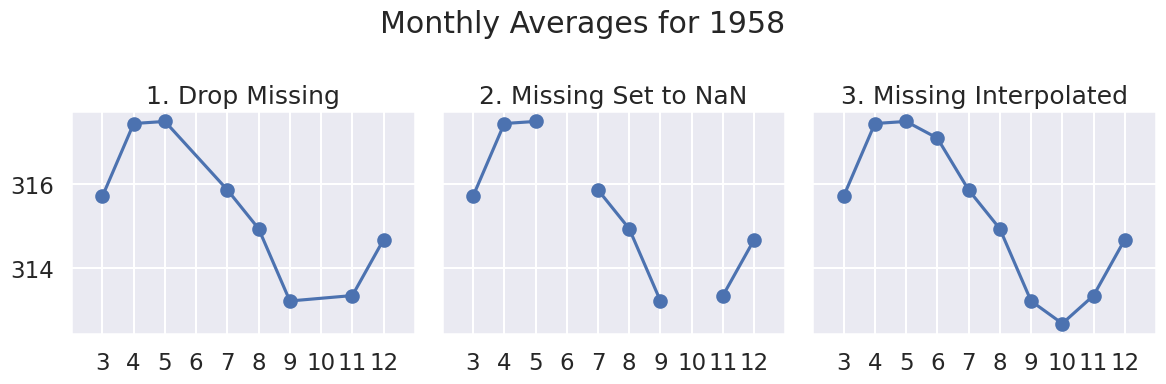

In [18]:
# results of plotting data in 1958

def line_and_points(data, ax, title):
    # assumes single year, hence Mo
    ax.plot('Mo', 'Avg', data=data)
    ax.scatter('Mo', 'Avg', data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

def data_year(data, year):
    return data[data["Yr"] == 1958]
    
# uses matplotlib subplots
# you may see more next week; focus on output for now
fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

year = 1958
line_and_points(data_year(co2_drop, year), axes[0], title="1. Drop Missing")
line_and_points(data_year(co2_NA, year), axes[1], title="2. Missing Set to NaN")
line_and_points(data_year(co2_impute, year), axes[2], title="3. Missing Interpolated")

fig.suptitle(f"Monthly Averages for {year}")
plt.tight_layout()

In the big picture since there are only 7 `Avg` values missing (**<1%** of 738 months), any of these approaches would work.

However there is some appeal to **option C: Imputing**:
* Shows seasonal trends for CO2
* We are plotting all months in our data as a line plot

<br/>

---
Let's replot our original figure with option 3:

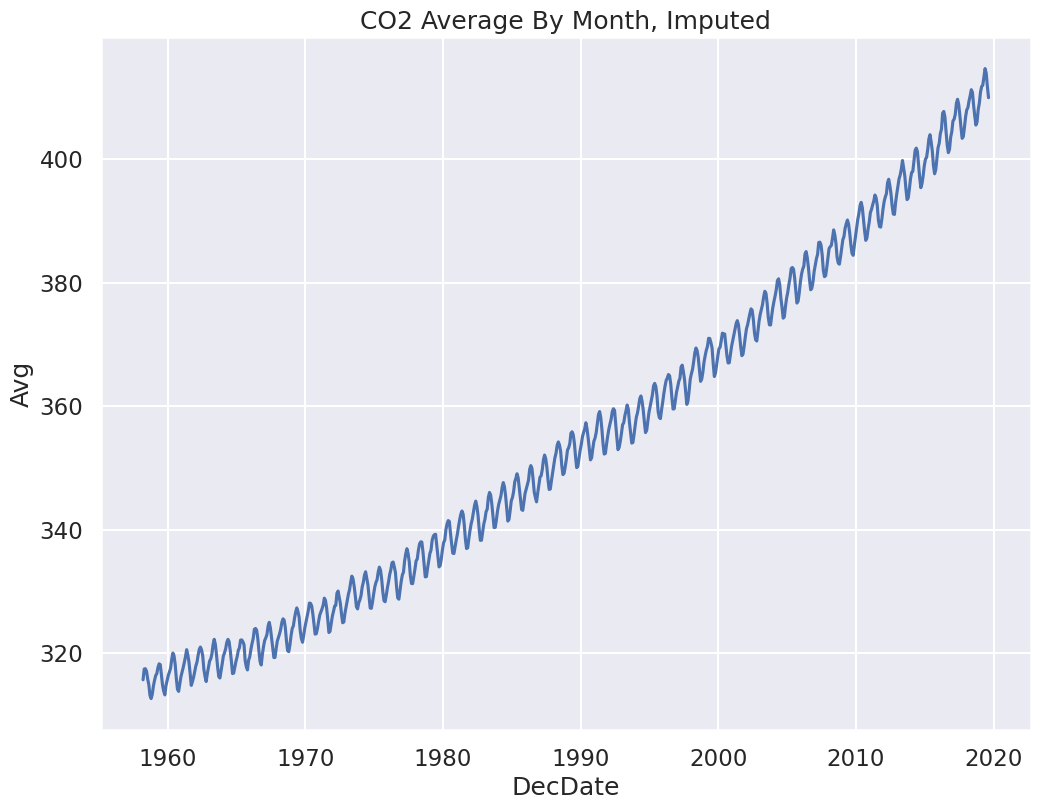

In [19]:
sns.lineplot(x='DecDate', y='Avg', data=co2_impute)
plt.title("CO2 Average By Month, Imputed");

Looks pretty close to what we see on the NOAA [website](https://gml.noaa.gov/ccgg/trends/)!

### Presenting the data: A Discussion on Data Granularity

From the description:
* monthly measurements are averages of average day measurements.
* The NOAA GML website has datasets for daily/hourly measurements too.

The data you present depends on your research question.

**How do CO2 levels vary by season?**
* You might want to keep average monthly data.

**Are CO2 levels rising over the past 50+ years, consistent with global warming predictions?**
* You might be happier with a **coarser granularity** of average year data!

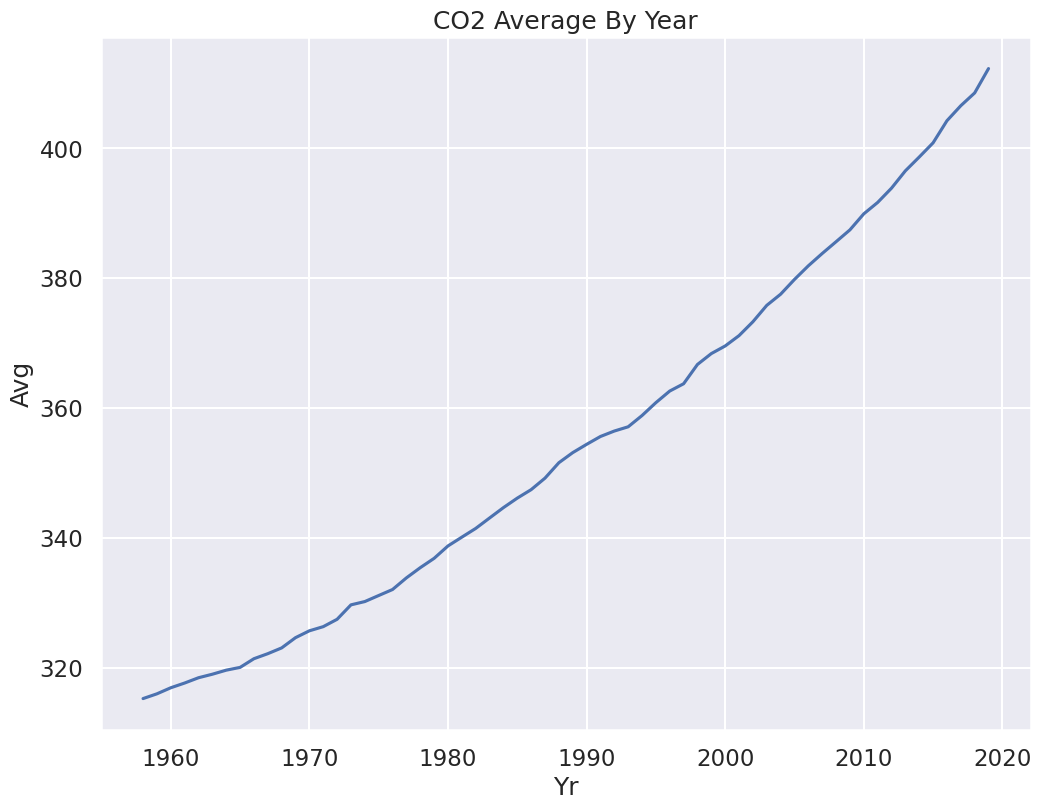

In [20]:
co2_year = co2_impute.groupby('Yr').mean()
sns.lineplot(x='Yr', y='Avg', data=co2_year)
plt.title("CO2 Average By Year");

Indeed, we see a rise by nearly 100 ppm of CO2 since Mauna Loa began recording in 1958.